In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
import time

import Featurizer as ft

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
pd.set_option('display.max_columns', 50)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import Imputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [12.0,8.0]

In [4]:
import category_encoders as ce

OHE = ce.OneHotEncoder( handle_unknown='ignore', use_cat_names=True)

BE = ce.BinaryEncoder( handle_unknown='ignore')
HE = ce.SumEncoder( handle_unknown='ignore')

TE1 = ce.TargetEncoder( handle_unknown='ignore')
TE2 = ce.TargetEncoder( handle_unknown='ignore')
TE3 = ce.TargetEncoder( handle_unknown='ignore')
TE4 = ce.TargetEncoder( handle_unknown='ignore')

In [5]:
df_train = pd.read_csv("../data/palabras.csv")

#mx = pd.read_csv("../data/mx_modified.csv").iloc[:,1:]

#df_train = df_train.join(mx.set_index('provincia'),on="provincia",how='inner')

#df_feature_descripcion = pd.read_csv("../data/word-features-reduced.csv", dtype=np.float16)

#df_train = df_train.join(df_feature_descripcion)

In [6]:
#df_train = pd.merge(df_train,mx,on="provincia",how="left")
df_train.shape

(240000, 85)

## Pre-processing

In [7]:
X = df_train.drop("precio", axis=1)
y = df_train['precio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [8]:
X_train_submit = X_train.copy()

In [9]:
X_train["ambientes"] = X_train["banos"] + X_train["habitaciones"]
X_train["ambientesygarage"] = X_train["banos"] + X_train["habitaciones"]+X_train["garages"]

X_test["ambientes"] = X_test["banos"] + X_test["habitaciones"]
X_test["ambientesygarage"] = X_test["banos"] + X_test["habitaciones"]+X_test["garages"]

In [10]:
X_train[ ft.getTarget1Cols() ] = X_train[ft.getAllCols()]
X_test[ ft.getTarget1Cols() ] = X_test[ft.getAllCols()]

X_train[ ft.getTarget2Cols() ] = X_train[["tipodepropiedad"]]
X_test[ ft.getTarget2Cols() ] = X_test[["tipodepropiedad"]]

X_train[ ft.getTarget3Cols() ] = X_train[ft.getAllCols()]
X_test[ ft.getTarget3Cols() ] = X_test[ft.getAllCols()]

X_train[ ft.getTarget4Cols() ] = X_train[ft.getAllCols()]
X_test[ ft.getTarget4Cols() ] = X_test[ft.getAllCols()]

In [11]:
X_train = ft.preprocess(X_train, OHE, BE, 'train', TE1, TE2, TE3, TE4, HE, y_train)
X_test = ft.preprocess(X_test, OHE, BE, 'test', TE1, TE2, TE3, TE4, HE)

--- 11.475393772125244 seconds ---
--- 2.0216026306152344 seconds ---


In [12]:
print(f"Original shapes: X={X.shape} y={y.shape}")
print(f"Train shapes: X={X_train.shape} y={y_train.shape}")
print(f"Test  shapes: X={X_test.shape}  y=-{y_test.shape}")

Original shapes: X=(240000, 84) y=(240000,)
Train shapes: X=(180000, 182) y=(180000,)
Test  shapes: X=(60000, 182)  y=-(60000,)


## Training

In [13]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=1750,n_jobs=6,objective="reg:squarederror",
                     max_depth= 11,min_child_weight = 1,colsample_bytree=0.5,
                     gamma=1, learning_rate=0.1, subsample=1)
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=11, min_child_weight=1, missing=None, n_estimators=1750,
             n_jobs=6, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [14]:
start_time = time.time()
model.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1330.5898342132568 seconds ---


## Predicciones

In [15]:
ft.predecir(model, X_train, y_train, X_test, y_test)

Entrenamiento: 99.8506%
Testeo: 84.4260%.
Mean abs error: 478903.4349.


In [16]:
plt.rcParams["figure.figsize"] = [15, 15]

importancia = model.feature_importances_

d = {'x':X_train.columns,'y':importancia}

df_importancia = pd.DataFrame(d)

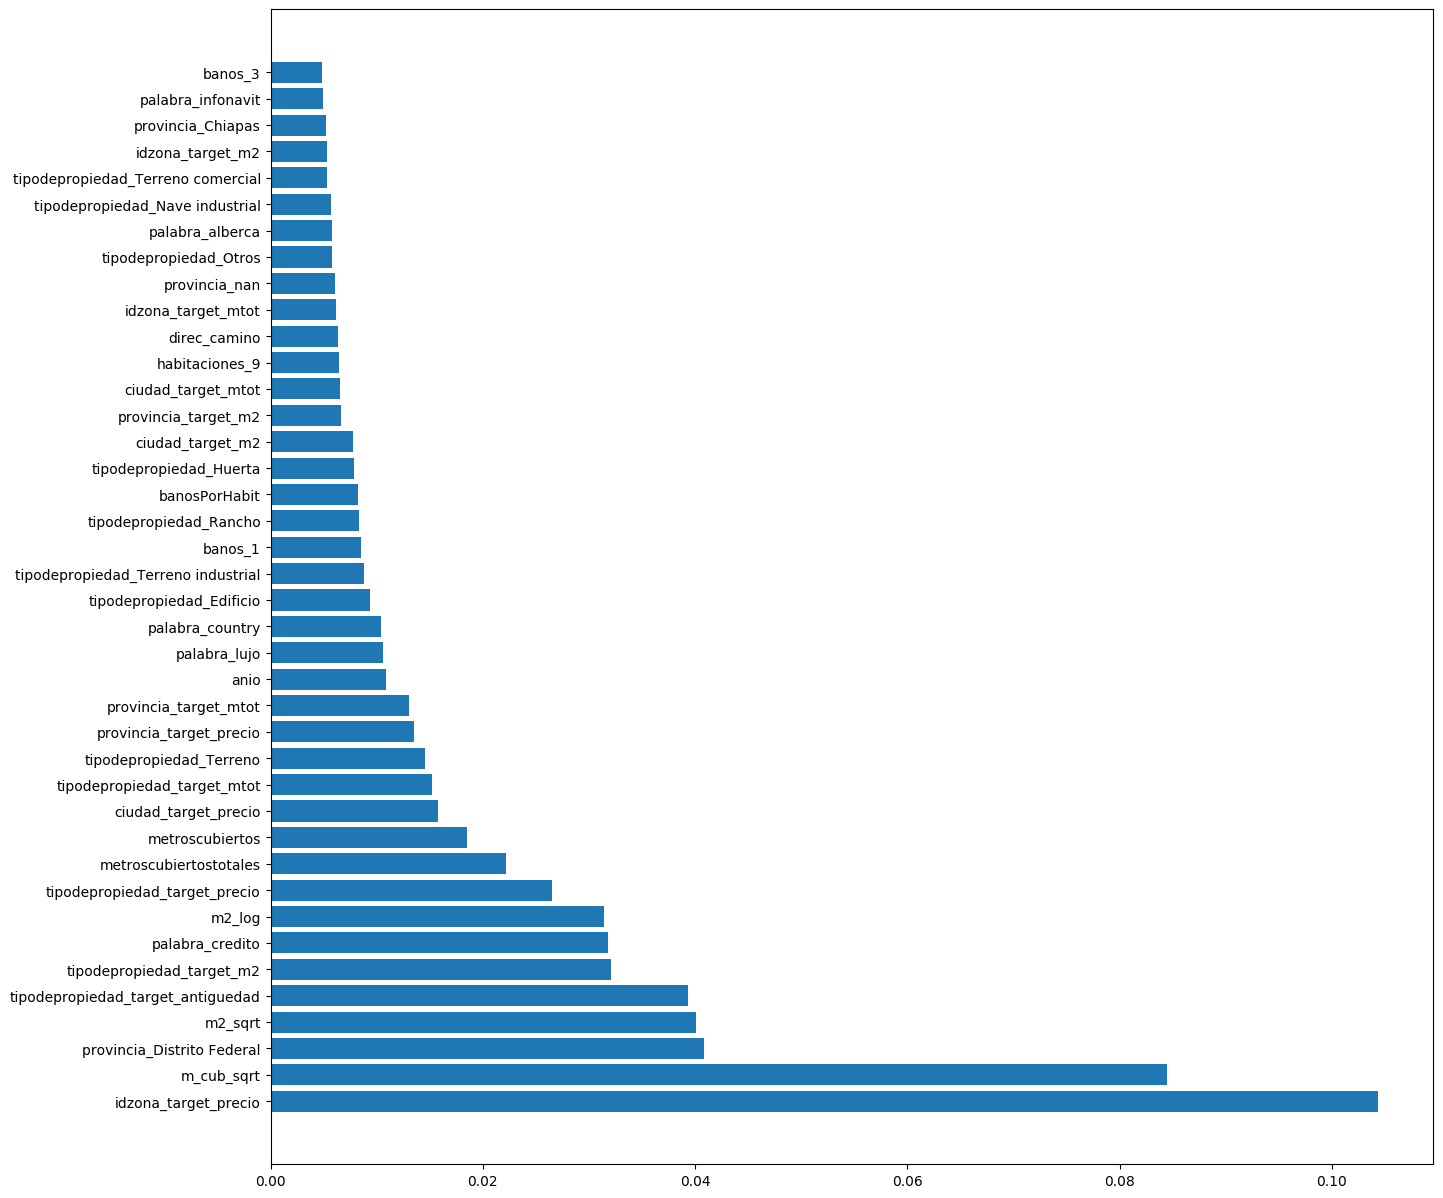

In [17]:
importancia = df_importancia.sort_values(by="y",ascending=False).head(40)
ax = plt.barh(importancia.x,importancia.y)

## Feature Importance

In [ ]:
from sklearn.feature_selection import SelectFromModel
start_time = time.time()

SFM = SelectFromModel(model, threshhold = 'mean',max_features = 130)

x_features = SFM.fit_transform(X_train, y_train)
columns = np.asarray(X_train.columns.values)
support = np.asarray(SFM.get_support())

columns_with_support = columns[support]
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
columns_with_support

In [ ]:
from sklearn.feature_selection import SelectKBest
start_time = time.time()

selection = SelectKBest(k=40)
x_features = selection.fit_transform(X_train, y_train)

columns = np.asarray(X_train.columns.values)
support = np.asarray(selection.get_support())

columns_with_support = columns[support]
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
columns_with_support

## Submission

In [18]:
df_test = pd.read_csv('../data/test.csv')


In [19]:
df = df_test.copy()
df = ft.init_test(df)
df = pd.merge(df,mx,on="provincia",how="left")

In [20]:
df["ambientes"] = df["banos"] + df["habitaciones"]
df["ambientesygarage"] = df["banos"] + df["habitaciones"]+df["garages"]

In [21]:
df[ ft.getTarget1Cols() ] = df[ft.getAllCols()]
df[ ft.getTarget2Cols() ] = df[["tipodepropiedad"]]
df[ ft.getTarget3Cols() ] = df[ft.getAllCols()]
df[ ft.getTarget4Cols() ] = df[ft.getAllCols()]

In [23]:
df = ft.preprocess(df, OHE, BE, 'test', TE1, TE2, TE3,TE4, HE)

--- 1.6333954334259033 seconds ---


In [25]:
#df, X_train = df.align(X_train,axis=1)


In [24]:
submit_prediction = model.predict( df )

In [35]:
#cols_diff = []
#t = X_train_submit.columns.values
#fs = df.columns.values
#i = 0
#for feat in t:
#    if feat != fs[i]:
#        cols_diff.append(feat)
#    i=+1
#display(cols_diff)        

In [ ]:
#pd.concat([df_test[['id']], pd.Series(submit_prediction)], axis=1).rename(columns={0:"target"}).to_csv("../data/submission13.csv", index=False)

In [25]:
from submission_helper import submission_output

output = submission_output(df_test, submit_prediction)

nombre_submit = 'submission31.csv'

output.to_csv('../data/'+nombre_submit, index=False)